In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [58]:
def get_num_non_numeric_value(values: pd.Series):
    nonNumericValue = values.isnull().sum()
    nonNumericValue = pd.to_numeric(values, errors='coerce').isnull().sum() - nonNumericValue
    return nonNumericValue

def contiene_decimali(series):
    return series.apply(lambda x: not float(x).is_integer() if pd.notna(x) else False).sum()

In [59]:
df = pd.read_csv('../../data/incidents.csv')
df.shape

/tmp/ipykernel_90716/4258821009.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/incidents.csv')


(239677, 28)

**Analisi Dtype degli attributi**

Come si può osservare, molti attributi non contengono il tipo corretto, analizzeremo dopo in dettaglio perché questo accade

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       239677 non-null  object 
 1   state                      239677 non-null  object 
 2   city_or_county             239677 non-null  object 
 3   address                    223180 non-null  object 
 4   latitude                   231754 non-null  float64
 5   longitude                  231754 non-null  float64
 6   congressional_district     227733 non-null  float64
 7   state_house_district       200905 non-null  float64
 8   state_senate_district      207342 non-null  float64
 9   participant_age1           147379 non-null  float64
 10  participant_age_group1     197558 non-null  object 
 11  participant_gender1        203315 non-null  object 
 12  min_age_participants       164879 non-null  object 
 13  avg_age_participants       16

**Distribuzione valori nulli**

<Axes: >

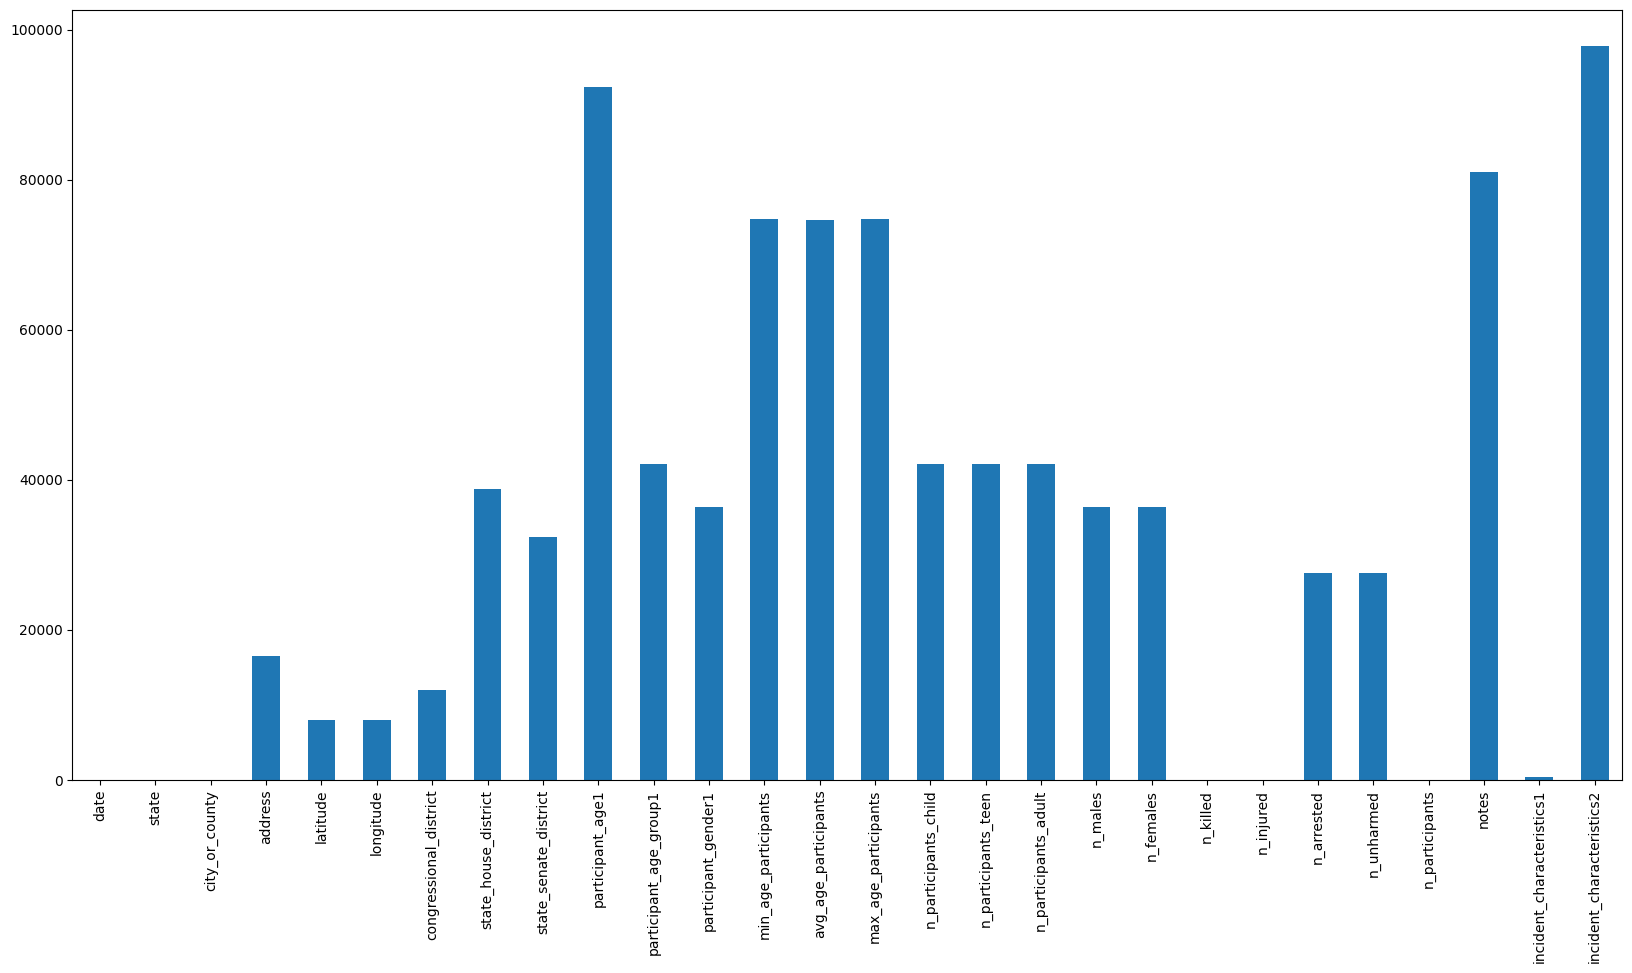

In [61]:
plt.figure(figsize=(20, 10))
df.isnull().sum().plot(kind='bar')

**Numero valori duplicati**

In [62]:
df.duplicated().sum()

253

**Controllo qualità campo date**

Come possiamo osservare, il campo date è formattato correttamente

In [63]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.date.isnull().sum()

0

* La distribuzione nei vari mesi per l’anno 2013 è molto inferiore rispetto agli altri anni (La stessa cosa accade per gli anni 2028, 2029, 2030).

    * Un potrebbe ipotizzare che gli anni 2028, 2029, 2030 in realtà corrispondano agli anni 2018, 2019 e 2020, ma questa ipotesi è altamente improbabile a causa del fatto che le distribuzioni nei vari mesi non rispettano gli altri anni
* Il periodo 2018 è corretto dato che la distribuzione nei mesi presenti rispecchia quella degli anni passati

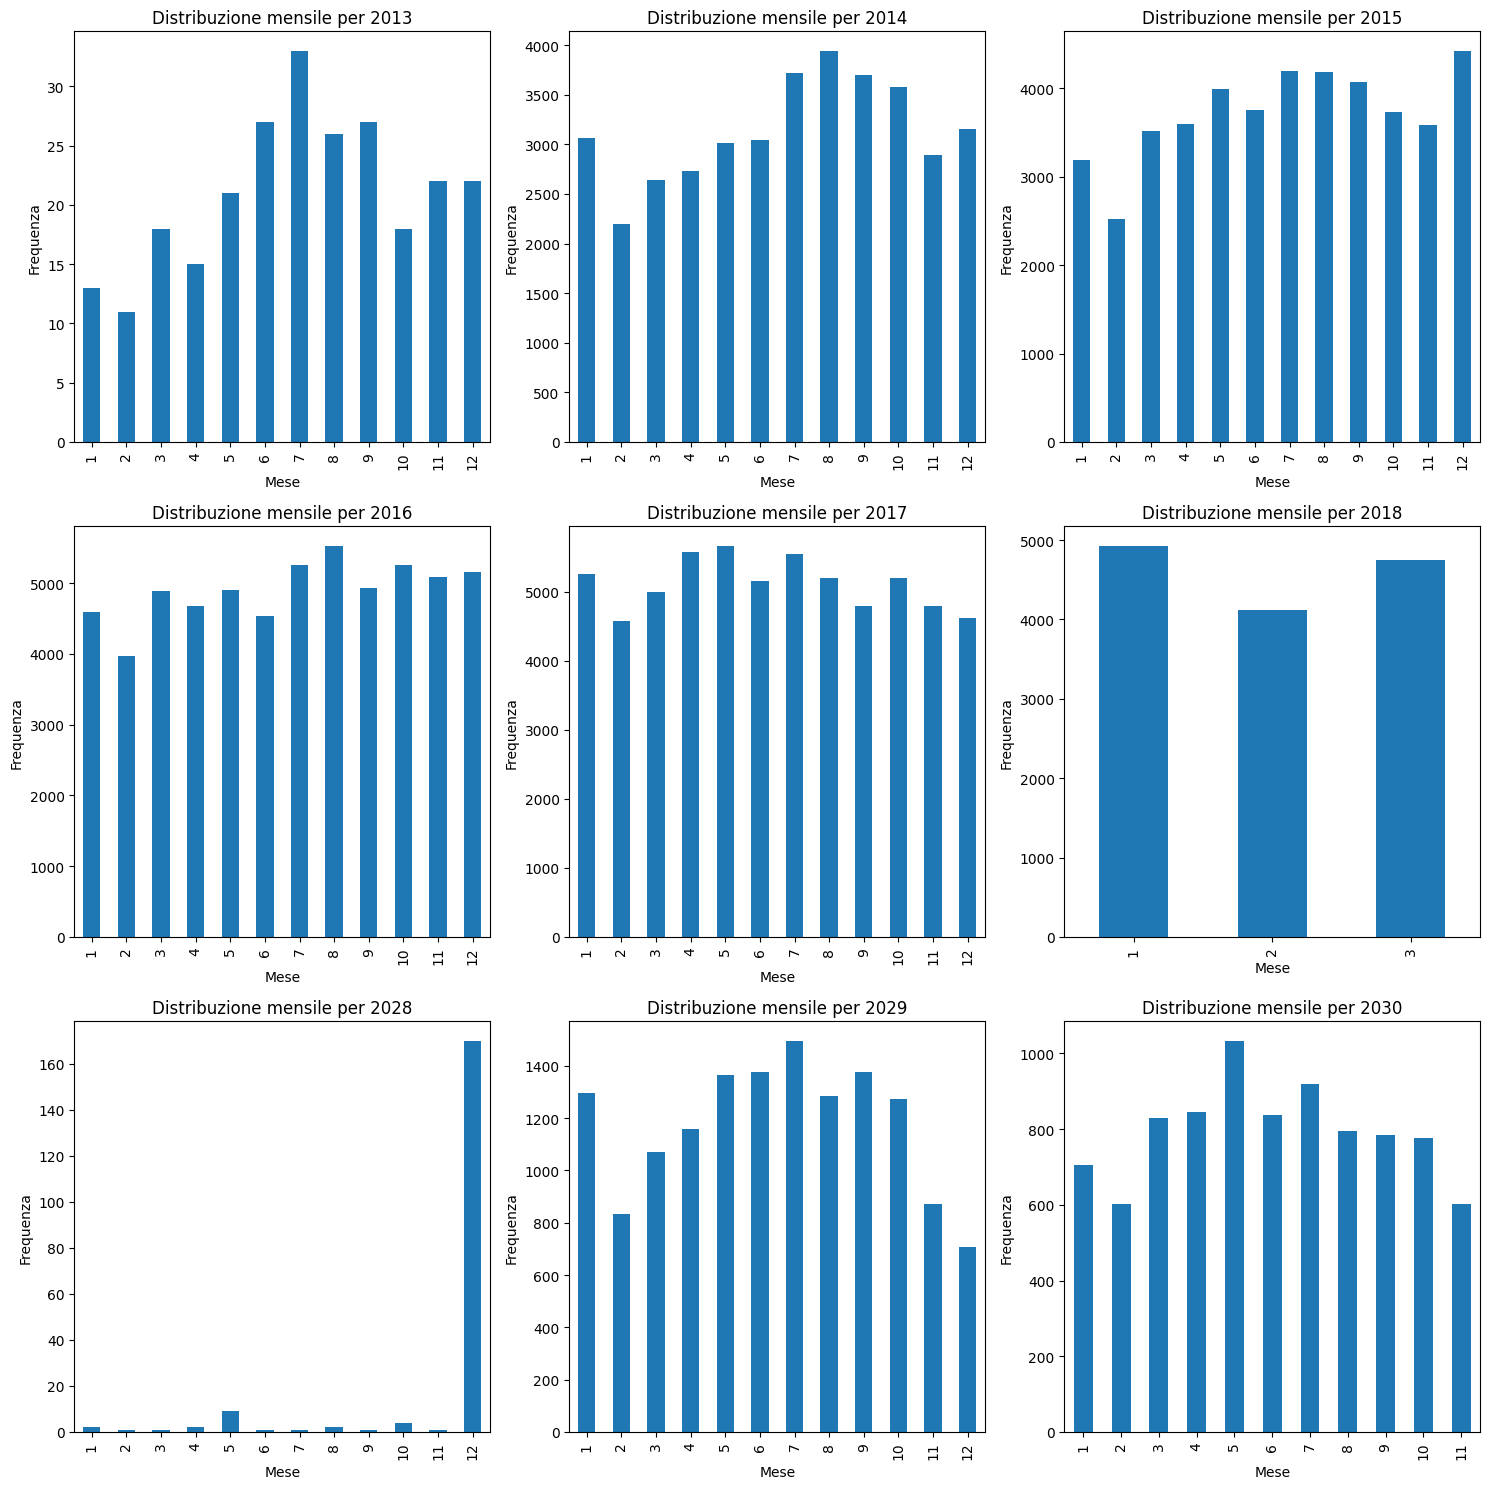

In [64]:
# Supponendo che 'df' sia il tuo DataFrame e 'date' sia la colonna con le date
df = df.sort_values(by='date')
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Crea un grafico per ogni anno nella griglia 3x3
unique_years = df['Year'].unique()
num_years = len(unique_years)

# Imposta la griglia 3x3
num_rows = 3
num_cols = 3

# Crea una figura e assicurati di avere abbastanza sottografici
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Itera attraverso gli anni e assegna ogni grafico a un sottografo
for i, year in enumerate(unique_years):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    
    # Crea il grafico
    df[df['Year'] == year]['Month'].value_counts(sort=False).plot(kind='bar', ax=ax)
    
    # Imposta il titolo e le etichette
    ax.set_title(f'Distribuzione mensile per {year}')
    ax.set_xlabel('Mese')
    ax.set_ylabel('Frequenza')

# Aggiusta la disposizione per evitare sovrapposizioni
plt.tight_layout()
plt.show()


**Controllo qualità campo state**

* In totale sono 51 valori (sono tutti Stati americani tranne District of Columbia - i.e. Washington DC)
* N.B. District of Columbia = Washington DC ≠ Washington (Infatti quest'ultimo è uno stato americano: https://it.wikipedia.org/wiki/Washington_(Stato))

In [65]:
print(df['state'].nunique())
df['state'].unique()

51


array(['Ohio', 'Pennsylvania', 'California', 'Colorado', 'North Carolina',
       'Oklahoma', 'New Mexico', 'Louisiana', 'Tennessee', 'Maryland',
       'Missouri', 'Illinois', 'Delaware', 'Utah', 'Georgia', 'Michigan',
       'Indiana', 'Mississippi', 'District of Columbia', 'New York',
       'Florida', 'Washington', 'South Carolina', 'Arizona', 'Kentucky',
       'New Jersey', 'Virginia', 'Wisconsin', 'Texas', 'Rhode Island',
       'Alabama', 'Kansas', 'Connecticut', 'West Virginia', 'Minnesota',
       'Nevada', 'Nebraska', 'Arkansas', 'Iowa', 'New Hampshire',
       'Massachusetts', 'Alaska', 'Hawaii', 'Wyoming', 'Idaho', 'Maine',
       'Oregon', 'Montana', 'North Dakota', 'Vermont', 'South Dakota'],
      dtype=object)

**Il campo city_or_county verrà analizzato e sistemato in dettaglio per il task 4**

**Il campo address è difficile da analizzare e non è molto utile per la nostra analisi, allora lo ignoriamo.**

**Controllo qualità campo latitude & longitude**
* Valori di latitude deve essere compreso tra -90, +90
* Valori di longitude deve essere compreso tra -180, +180

In [66]:
print("Latitudine massima: ", df.latitude.max())
print("Latitudine minima: ", df.latitude.min())

print("longitude massima: ", df.latitude.max())
print("longitude minima: ", df.longitude .max())


Latitudine massima:  71.3368
Latitudine minima:  19.1114
longitude massima:  71.3368
longitude minima:  97.4331


Alcuni punti non si trovano negli stati uniti
(Come si può osservare dalla mappa, alcuni punti si trovano in cina)

/tmp/ipykernel_90716/2099206995.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


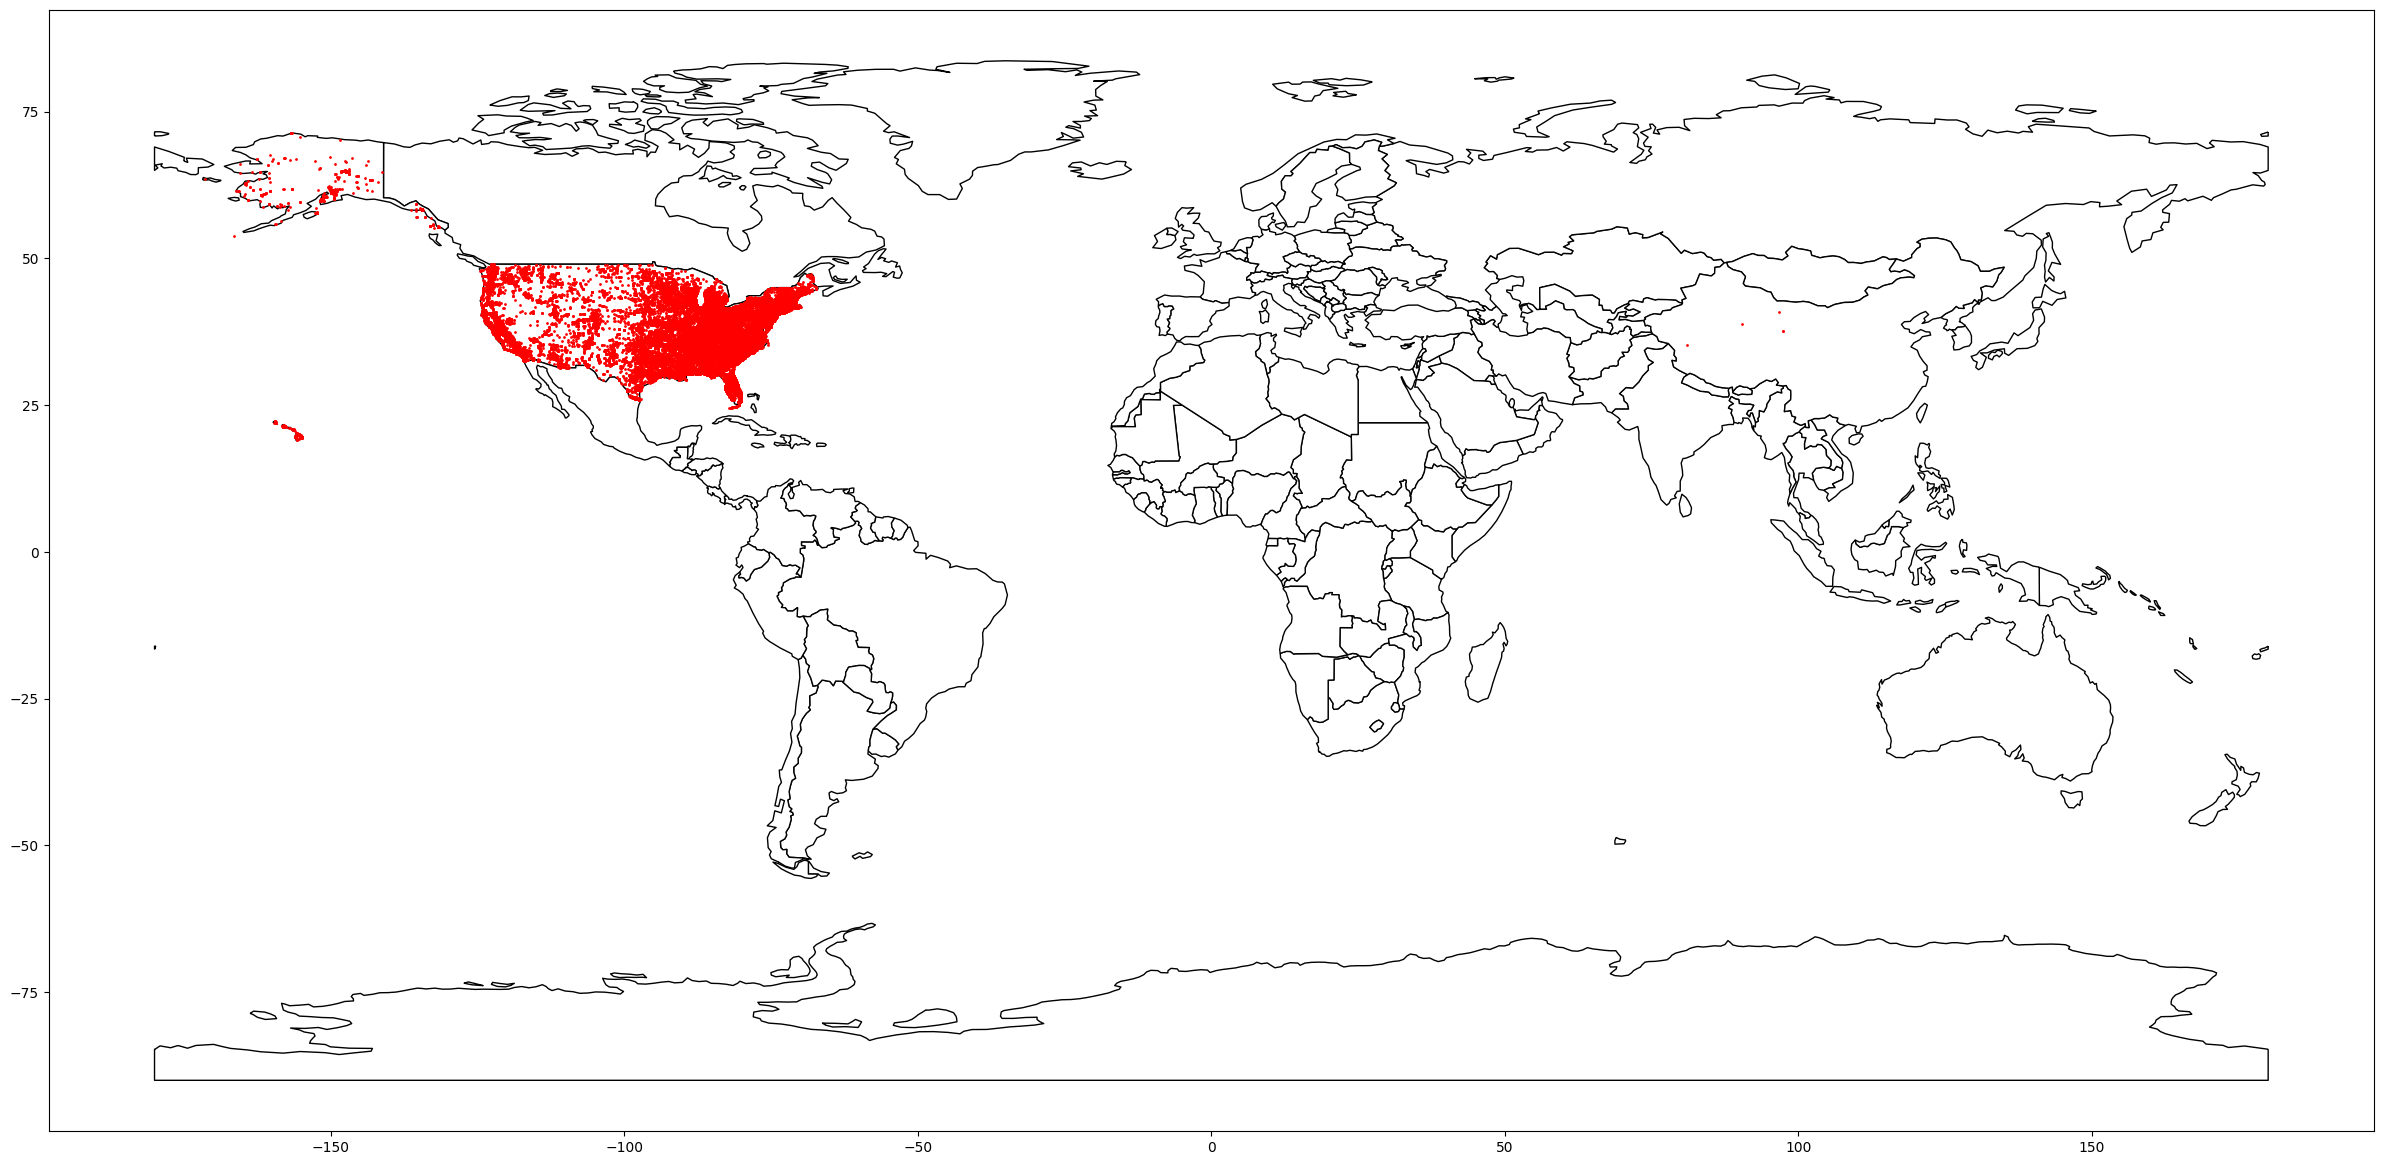

In [67]:
# Carica la mappa del North America
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

fig, ax = plt.subplots(figsize=(30, 30))

# Disegna la mappa della terra
world.plot(ax=ax, color='white', edgecolor='black')

gdf.plot(ax=ax, marker='o', color='red', markersize=1)
plt.show()

**participant_age_group1**

Il campo è corretto

In [69]:
df.participant_age_group1.unique()

array(['Adult 18+', nan, 'Teen 12-17', 'Child 0-11'], dtype=object)

**Controllo campi numerici**

In [79]:
columns = ['min_age_participants', 'avg_age_participants',
           'max_age_participants', 'n_participants_child', 'n_participants_teen',
           'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
           'n_arrested', 'n_unharmed', 'n_participants']

for column in columns:
    print(f"=============={column}==============")
    print(f"Non numeric values for {column}: ", get_num_non_numeric_value(df[column]))
    df[column] = pd.to_numeric(df[column], errors='coerce')

    print(f"Decimal values for {column}: ", contiene_decimali(df[column]))
    print(f"{column}: ", df[column].max())
    print(f"{column}: ", df[column].min())

==============min_age_participants==============
Non numeric values for min_age_participants:  0
Decimal values for min_age_participants:  0
min_age_participants:  900000000000.0
min_age_participants:  -1000.0
==============avg_age_participants==============
Non numeric values for avg_age_participants:  0
Decimal values for avg_age_participants:  0
avg_age_participants:  871916284.0
avg_age_participants:  -1000.0
==============max_age_participants==============
Non numeric values for max_age_participants:  0
Decimal values for max_age_participants:  0
max_age_participants:  8300000.0
max_age_participants:  -1000.0
==============n_participants_child==============
Non numeric values for n_participants_child:  0
Decimal values for n_participants_child:  0
n_participants_child:  886365.0
n_participants_child:  -977.0
==============n_participants_teen==============
Non numeric values for n_participants_teen:  0
Decimal values for n_participants_teen:  0
n_participants_teen:  762487.0
n_part

**notes, incident_characteristics1, incident_characteristics2**

Questi campi sono complessi da analizzare => vengono usati solo per comprendere il valore degli altri campi

**n_participants==0**

Le entry con n_participants==0 contengono tanti valori null

<Axes: >

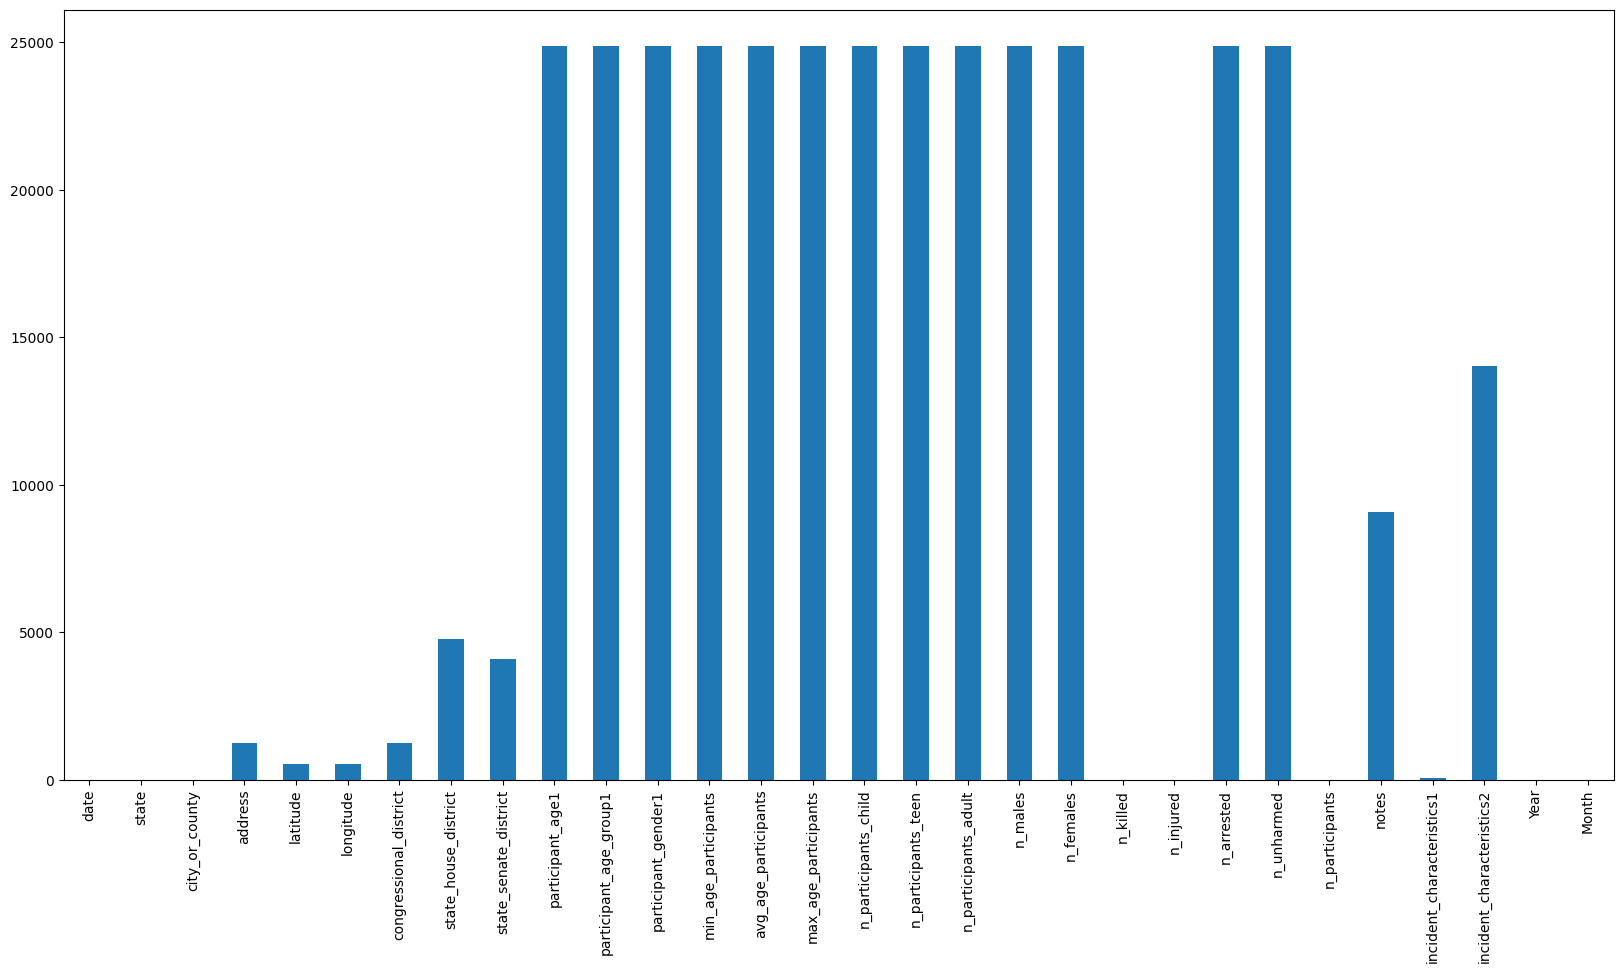

In [82]:
data = df[df.n_participants == 0]
plt.figure(figsize=(20, 10))
data.isnull().sum().plot(kind='bar')

**Inconsistenza con incidents incident_characteristics1**

Esistono casi in cui notes e incident_characteristcs1 fanno riferimento a uno o più morti, ma n_killed=0 ⇒ eliminiamo queste entry (impossibile stabilirne la correttezza). Esempio:

In [87]:
df[(df["incident_characteristics1"] == "Shot - Dead (murder, accidental, suicide)") 
    & (df["n_killed"] == 0)].head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,Year,Month
162572,2013-11-22,Pennsylvania,Philadelphia,5100 Parrish St,39.9669,-75.2229,2.0,190.0,7.0,30.0,...,0,1,1.0,0.0,2.0,"Pit gang vic shot 10 times, inj, suspect in Gr...","Shot - Dead (murder, accidental, suicide)",Gang involvement,2013,11
132846,2014-01-10,Michigan,Flint,3600 block of Sterling Street,43.0478,-83.7205,5.0,34.0,27.0,49.0,...,0,0,NaN,NaN,1.0,"Man shot, killed in street; unclear.","Shot - Dead (murder, accidental, suicide)",NaN,2014,1
27726,2014-01-14,Texas,Parker (county),FM 3325,33.0421,-96.6123,3.0,89.0,8.0,34.0,...,0,1,1.0,0.0,1.0,Perp pointed gun at officers after long car ch...,"Shot - Dead (murder, accidental, suicide)",Officer Involved Incident,2014,1
124147,2014-01-24,Ohio,Chesapeake,1904 County Road 124,38.4386,-82.4787,6.0,93.0,17.0,NaN,...,0,0,NaN,NaN,2.0,NaN,"Shot - Dead (murder, accidental, suicide)",NaN,2014,1
35400,2014-01-24,North Carolina,Chapel Hill,342 West Rosemary Street,35.9119,-79.0622,4.0,56.0,23.0,31.0,...,0,1,0.0,2.0,3.0,NaN,"Shot - Dead (murder, accidental, suicide)",NaN,2014,1


Similmente accade per n_injured

In [88]:
df[(df["incident_characteristics1"] == "Shot - Wounded/Injured") 
    & (df["n_injured"] == 0)].head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,Year,Month
25413,2013-09-12,Tennessee,Crab Orchard,NaN,35.9576,-84.8407,6.0,25.0,15.0,22.0,...,4,0,2.0,0.0,6.0,NaN,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)",2013,9
207089,2013-10-26,Arizona,Phoenix,17th Avenue and Hazelwood Street,33.5042,-112.0960,7.0,24.0,24.0,66.0,...,5,0,0.0,0.0,5.0,Suspect was bothered by barking of neighbors d...,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)",2013,10
168700,2013-10-29,South Carolina,Bradley (Callison),Callison Highway,33.9881,-82.2888,3.0,12.0,10.0,26.0,...,5,0,0.0,0.0,6.0,Perpetrator laid in wait to kill victims; acti...,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)",2013,10
238122,2014-01-01,District of Columbia,Washington,5100 block of Fitch Street SE,38.8807,-76.9293,1.0,NaN,NaN,NaN,...,0,0,NaN,NaN,0.0,NaN,Shot - Wounded/Injured,NaN,2014,1
171135,2014-01-01,District of Columbia,Washington,2700 block of Langston Place SE,38.8569,-76.9718,1.0,NaN,NaN,NaN,...,0,0,NaN,NaN,0.0,NaN,Shot - Wounded/Injured,NaN,2014,1


In questo caso si ha No Injuries, ma n_injured ≠ 0

In [90]:
df[(df["incident_characteristics1"] == "Shots Fired - No Injuries") 
    & (df["n_injured"] != 1)].head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,Year,Month
172652,2014-01-01,Arizona,Rio Rico,Yave Court,31.4674,-110.9740,3.0,2.0,2.0,NaN,...,0,0,NaN,NaN,0.0,bullets entered home,Shots Fired - No Injuries,NaN,2014,1
58671,2014-01-01,Florida,Fort Myers,2600 block of Edison Avenue,26.6336,-81.8601,19.0,78.0,30.0,NaN,...,0,0,0.0,2.0,2.0,NaN,Shots Fired - No Injuries,"Drive-by (car to street, car to car)",2014,1
212185,2014-01-01,Virginia,Richmond,3215 E Broad St,37.5266,-77.4125,3.0,70.0,16.0,NaN,...,0,0,NaN,NaN,0.0,bullet strikes car near Chimborazo Park,Shots Fired - No Injuries,NaN,2014,1
203201,2014-01-01,Iowa,Fort Dodge,648 Fourth Ave. N.,42.5085,-94.1894,4.0,9.0,5.0,NaN,...,0,0,0.0,1.0,1.0,"bullets entered home, bullet strikes car",Shots Fired - No Injuries,NaN,2014,1
207946,2014-01-01,Pennsylvania,Hazleton,Hazleton Apartments,40.9752,-75.9845,11.0,NaN,NaN,NaN,...,0,0,NaN,NaN,0.0,bullets entered home,Shots Fired - No Injuries,NaN,2014,1


**Incidenti avvenuti lo stesso giorno e nello stesso luogo**

Alcuni dataframe contengono la stessa Latitudine & longitudine, ma i valori di address e city_or_county sono diversi

In [104]:
duplicati = df.duplicated(subset=["latitude", "longitude", "date"], keep=False)
print("Numero di entry duplicate: ", len(df[duplicati]))
df[duplicati].sort_values(by=["latitude", "longitude", "date"]).head()

Numero di entry duplicate:  10302


,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,Year,Month
23479,2016-07-08,Florida,Key West,NaN,24.5611,-81.7732,26.0,120.0,39.0,44.0,...,0,0,1.0,0.0,1.0,Bail Bondsman walked into Circle K with gun in...,Institution/Group/Business,Non-Shooting Incident,2016,7
175822,2016-07-08,Florida,Key West,NaN,24.5611,-81.7732,26.0,120.0,39.0,23.0,...,0,0,1.0,0.0,1.0,"fed charges, Dec 2015, drugs, Glock 9mm, DATE ...",Non-Shooting Incident,Drug involvement,2016,7
174264,2017-09-15,Florida,Miami,NaN,25.7789,-80.1980,24.0,113.0,40.0,24.0,...,1,0,0.0,0.0,1.0,NaN,"Shot - Dead (murder, accidental, suicide)",NaN,2017,9
90714,2017-09-15,Florida,Miami,NaN,25.7789,-80.1980,24.0,113.0,40.0,16.0,...,0,0,4.0,0.0,4.0,NaN,Non-Shooting Incident,Car-jacking,2017,9
13755,2016-03-13,Florida,Miami,2100 NW 42nd Avenue,25.7944,-80.2792,27.0,111.0,39.0,NaN,...,0,0,NaN,NaN,0.0,9mm,Non-Shooting Incident,TSA Action,2016,3
